# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import OrderedDict
from tqdm import tqdm
import time
from datetime import timedelta

## Load the Dataset

We'll start loading the training data set and use it to compute the mean and std across the channels. These values will be used in our transform step.

In [2]:
train_imgs = torchvision.datasets.CIFAR10(root='./data',train=True,download=True)
train_imgs = train_imgs.data/255

Files already downloaded and verified


In [3]:
means = train_imgs.mean(axis=(0,1,2))
stds  = train_imgs.std(axis=(0,1,2))
means, stds

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

We'll then create the tramsforms and load train and validation data.

In [4]:
train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                       transforms.RandomCrop(32,padding=4),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ColorJitter(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(means,stds)])

valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(means,stds)])

Next, we will load the datasets and apply the transformation.

In [5]:
train_data = torchvision.datasets.CIFAR10(root='./data',train=True, download=True,transform=train_transforms)
valid_data = torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=valid_transforms)

Files already downloaded and verified
Files already downloaded and verified


Finally, we create proper dataloaders to be used later.

In [6]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Exploring the Dataset

We will use the prebuilt (but modified) function called show5 to see a sample of the data.

In [8]:
def show5(img_loader,means=None,stds=None):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    
    if means is not None:
        images = images * stds[:, None, None] + means[:, None, None]
    
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(np.rot90(image.T, k=3))
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat


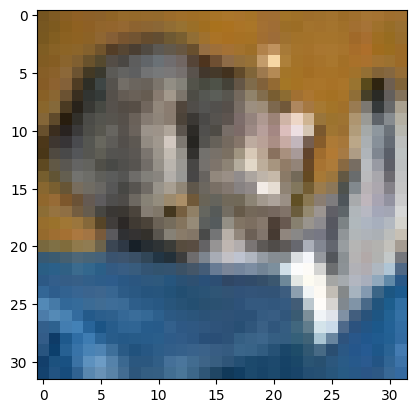

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ship


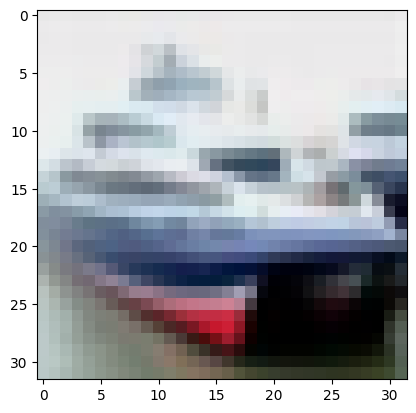

ship


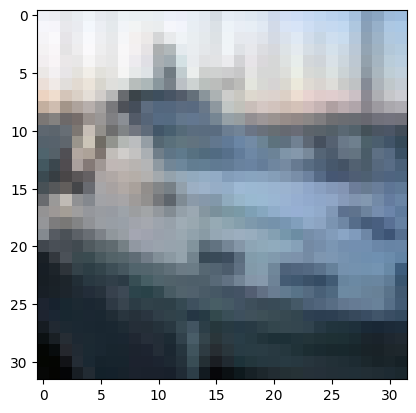

plane


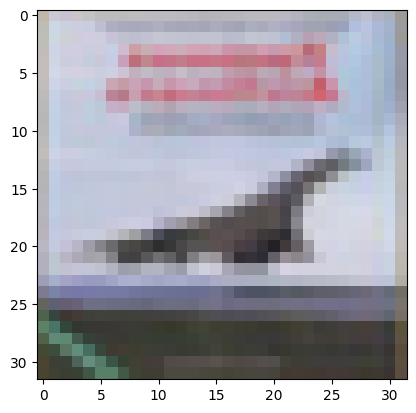

frog


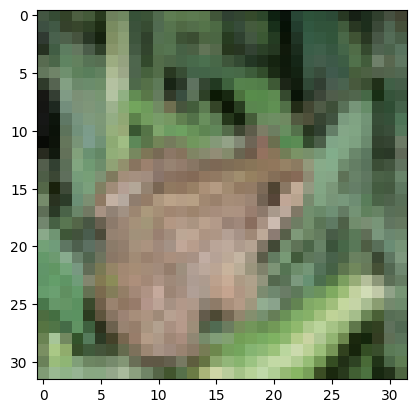

In [9]:
show5(validloader,means,stds)

## Building the Network

Below I create my network. I start from a LeNet-style architecture using the standard 32x32 image size. 
However, I add some additional steps to improve the architecture. I add BatchNorm for stabilization after the convolutional layers, as well as Dropout for regularization after the linear layers. Finally, I add non linear activation after each step.

In [10]:
nnetwork = nn.Sequential(OrderedDict([
                        ('conv1',nn.Conv2d(3,16,5)),
                        ('bn1', nn.BatchNorm2d(16)),
                        ('relu1',nn.ReLU()),
                        ('pool1',nn.MaxPool2d(2,2)),
                        ('conv2',nn.Conv2d(16,32,5)),
                        ('bn2', nn.BatchNorm2d(32)),
                        ('relu2',nn.ReLU()),
                        ('pool2',nn.MaxPool2d(2,2)),
                        ('conv3', nn.Conv2d(32,64,3)),
                        ('bn3', nn.BatchNorm2d(64)),
                        ('relu3', nn.ReLU()),
                        ('pool3', nn.MaxPool2d(2,2)),
                        ('flatten',nn.Flatten()),
                        ('fc1',nn.Linear(64,128)),
                        ('relu3',nn.ReLU()),
                        ('dropout1',nn.Dropout(0.5)),
                        ('fc2',nn.Linear(128,128)),
                        ('relu4',nn.ReLU()),
                        ('dropout2',nn.Dropout(0.5)),
                        ('fc3', nn.Linear(128,10)),
                        ('output', nn.LogSoftmax(dim=1))]))

nnetwork

Sequential(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (relu4): ReL

I will also use an accelerator for training. Below we check if GPU is available and if so bring over the model.

In [11]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
nnetwork.to(device); # Send the model to cpu or cuda accordingly
print('We are working on {}.'.format(device.upper()))

We are working on CUDA.


Then, I initiate the criterion and the optimizer, including a schedule to reduce the learning rate as we progress through the epochs.

In [12]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(nnetwork.parameters(), lr=0.003)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)

In [13]:
model_path = pd.DataFrame(columns=['Epoch','Steps','Train Loss','Validation Loss','Validation Accuracy'])

Now, we are ready to train the model.

In [14]:
epochs = 30
train_losses, valid_losses, print_every = [], [], 250
_start = time.time()
for e in range(epochs):
    running_loss, steps = 0, 0 
    for images, labels in tqdm(trainloader):
        steps += 1
        images, labels = images.to(device), labels.to(device) 
        
        optimizer.zero_grad() 
        output = nnetwork.forward(images) 
        loss = criterion(output,labels) 
        loss.backward() 
        optimizer.step() 
        running_loss += loss.item()
        
        if steps % print_every == 0:

            nnetwork.eval() 
            valid_loss, accuracy = 0, 0

            with torch.no_grad():
                running_valid_loss = 0
                for images, labels in validloader:

                    images, labels = images.to(device), labels.to(device) 

                    outputs = nnetwork.forward(images)
                    valid_loss += criterion(outputs,labels)
                    running_valid_loss += valid_loss.item()

                    ps = torch.exp(outputs)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor))

            train_losses.append(running_loss/len(trainloader))
            valid_losses.append(running_valid_loss/len(validloader))

            nnetwork.train() 

            model_path = pd.concat([model_path,pd.DataFrame([e+1,steps,running_loss/len(trainloader),running_valid_loss/len(validloader),100*accuracy.item()/len(validloader)],index=model_path.columns).T])
            
            print('Epoch: {}/{}  |  Steps: {}/{}  |  Train Loss: {:.3f}  |  Validation Loss: {:.3f}  |  Validation Accuracy: {:.2f}'.format(
                  e+1,epochs,steps,len(trainloader),running_loss/len(trainloader),running_valid_loss/len(validloader),100*accuracy/len(validloader)))
            
            

 32%|███▏      | 252/782 [00:17<02:40,  3.30it/s]

Epoch: 1/30  |  Steps: 250/782  |  Train Loss: 0.615  |  Validation Loss: 136.332  |  Validation Accuracy: 37.50


 64%|██████▍   | 503/782 [00:32<01:05,  4.23it/s]

Epoch: 1/30  |  Steps: 500/782  |  Train Loss: 1.166  |  Validation Loss: 117.412  |  Validation Accuracy: 45.50


 96%|█████████▋| 754/782 [00:46<00:06,  4.28it/s]

Epoch: 1/30  |  Steps: 750/782  |  Train Loss: 1.680  |  Validation Loss: 111.527  |  Validation Accuracy: 47.98


 32%|███▏      | 252/782 [00:14<02:46,  3.17it/s]

Epoch: 2/30  |  Steps: 250/782  |  Train Loss: 0.496  |  Validation Loss: 107.606  |  Validation Accuracy: 49.90


 64%|██████▍   | 504/782 [00:29<01:05,  4.27it/s]

Epoch: 2/30  |  Steps: 500/782  |  Train Loss: 0.981  |  Validation Loss: 106.851  |  Validation Accuracy: 51.72


 96%|█████████▌| 752/782 [00:43<00:09,  3.10it/s]

Epoch: 2/30  |  Steps: 750/782  |  Train Loss: 1.454  |  Validation Loss: 102.652  |  Validation Accuracy: 53.24


 32%|███▏      | 253/782 [00:14<02:04,  4.26it/s]

Epoch: 3/30  |  Steps: 250/782  |  Train Loss: 0.459  |  Validation Loss: 100.681  |  Validation Accuracy: 52.86


 64%|██████▍   | 502/782 [00:29<01:28,  3.17it/s]

Epoch: 3/30  |  Steps: 500/782  |  Train Loss: 0.913  |  Validation Loss: 100.966  |  Validation Accuracy: 55.47


 96%|█████████▋| 754/782 [00:43<00:06,  4.24it/s]

Epoch: 3/30  |  Steps: 750/782  |  Train Loss: 1.359  |  Validation Loss: 93.912  |  Validation Accuracy: 57.51


 32%|███▏      | 253/782 [00:14<02:17,  3.86it/s]

Epoch: 4/30  |  Steps: 250/782  |  Train Loss: 0.439  |  Validation Loss: 93.800  |  Validation Accuracy: 57.53


 64%|██████▍   | 502/782 [00:29<01:27,  3.19it/s]

Epoch: 4/30  |  Steps: 500/782  |  Train Loss: 0.877  |  Validation Loss: 91.167  |  Validation Accuracy: 58.52


 96%|█████████▋| 754/782 [00:43<00:06,  4.25it/s]

Epoch: 4/30  |  Steps: 750/782  |  Train Loss: 1.312  |  Validation Loss: 90.268  |  Validation Accuracy: 59.32


 32%|███▏      | 252/782 [00:14<02:46,  3.19it/s]

Epoch: 5/30  |  Steps: 250/782  |  Train Loss: 0.424  |  Validation Loss: 89.796  |  Validation Accuracy: 59.80


 64%|██████▍   | 502/782 [00:29<01:28,  3.16it/s]

Epoch: 5/30  |  Steps: 500/782  |  Train Loss: 0.850  |  Validation Loss: 87.446  |  Validation Accuracy: 60.54


 96%|█████████▋| 754/782 [00:43<00:06,  4.32it/s]

Epoch: 5/30  |  Steps: 750/782  |  Train Loss: 1.276  |  Validation Loss: 87.902  |  Validation Accuracy: 60.16


 32%|███▏      | 253/782 [00:14<02:01,  4.36it/s]

Epoch: 6/30  |  Steps: 250/782  |  Train Loss: 0.413  |  Validation Loss: 87.313  |  Validation Accuracy: 60.81


 64%|██████▍   | 502/782 [00:29<01:26,  3.22it/s]

Epoch: 6/30  |  Steps: 500/782  |  Train Loss: 0.834  |  Validation Loss: 85.956  |  Validation Accuracy: 60.48


 96%|█████████▋| 754/782 [00:43<00:06,  4.40it/s]

Epoch: 6/30  |  Steps: 750/782  |  Train Loss: 1.249  |  Validation Loss: 86.900  |  Validation Accuracy: 60.74


 32%|███▏      | 253/782 [00:14<02:06,  4.18it/s]

Epoch: 7/30  |  Steps: 250/782  |  Train Loss: 0.415  |  Validation Loss: 84.724  |  Validation Accuracy: 61.96


 64%|██████▍   | 502/782 [00:29<01:25,  3.26it/s]

Epoch: 7/30  |  Steps: 500/782  |  Train Loss: 0.826  |  Validation Loss: 84.218  |  Validation Accuracy: 62.60


 96%|█████████▌| 752/782 [00:43<00:10,  2.95it/s]

Epoch: 7/30  |  Steps: 750/782  |  Train Loss: 1.232  |  Validation Loss: 81.457  |  Validation Accuracy: 63.90


 32%|███▏      | 253/782 [00:15<02:06,  4.17it/s]

Epoch: 8/30  |  Steps: 250/782  |  Train Loss: 0.406  |  Validation Loss: 85.546  |  Validation Accuracy: 61.28


 64%|██████▍   | 503/782 [00:29<01:14,  3.72it/s]

Epoch: 8/30  |  Steps: 500/782  |  Train Loss: 0.813  |  Validation Loss: 83.749  |  Validation Accuracy: 62.80


 96%|█████████▌| 752/782 [00:44<00:09,  3.01it/s]

Epoch: 8/30  |  Steps: 750/782  |  Train Loss: 1.213  |  Validation Loss: 82.683  |  Validation Accuracy: 63.43


 32%|███▏      | 252/782 [00:15<02:56,  3.00it/s]

Epoch: 9/30  |  Steps: 250/782  |  Train Loss: 0.401  |  Validation Loss: 81.844  |  Validation Accuracy: 63.53


 64%|██████▍   | 504/782 [00:30<01:09,  3.98it/s]

Epoch: 9/30  |  Steps: 500/782  |  Train Loss: 0.798  |  Validation Loss: 82.690  |  Validation Accuracy: 63.02


 96%|█████████▋| 753/782 [00:44<00:06,  4.33it/s]

Epoch: 9/30  |  Steps: 750/782  |  Train Loss: 1.200  |  Validation Loss: 79.870  |  Validation Accuracy: 64.13


 32%|███▏      | 253/782 [00:14<02:01,  4.37it/s]

Epoch: 10/30  |  Steps: 250/782  |  Train Loss: 0.391  |  Validation Loss: 81.259  |  Validation Accuracy: 64.10


 64%|██████▍   | 502/782 [00:28<01:26,  3.22it/s]

Epoch: 10/30  |  Steps: 500/782  |  Train Loss: 0.784  |  Validation Loss: 81.209  |  Validation Accuracy: 64.76


 96%|█████████▋| 754/782 [00:43<00:06,  4.32it/s]

Epoch: 10/30  |  Steps: 750/782  |  Train Loss: 1.176  |  Validation Loss: 76.858  |  Validation Accuracy: 65.47


 32%|███▏      | 254/782 [00:14<02:01,  4.33it/s]

Epoch: 11/30  |  Steps: 250/782  |  Train Loss: 0.385  |  Validation Loss: 77.926  |  Validation Accuracy: 65.66


 64%|██████▍   | 504/782 [00:28<01:03,  4.37it/s]

Epoch: 11/30  |  Steps: 500/782  |  Train Loss: 0.777  |  Validation Loss: 81.309  |  Validation Accuracy: 64.52


 96%|█████████▋| 753/782 [00:43<00:06,  4.26it/s]

Epoch: 11/30  |  Steps: 750/782  |  Train Loss: 1.167  |  Validation Loss: 78.576  |  Validation Accuracy: 65.62


 32%|███▏      | 253/782 [00:14<02:04,  4.26it/s]

Epoch: 12/30  |  Steps: 250/782  |  Train Loss: 0.384  |  Validation Loss: 77.178  |  Validation Accuracy: 65.97


 64%|██████▍   | 504/782 [00:29<01:04,  4.31it/s]

Epoch: 12/30  |  Steps: 500/782  |  Train Loss: 0.770  |  Validation Loss: 76.520  |  Validation Accuracy: 66.07


 96%|█████████▋| 753/782 [00:43<00:06,  4.34it/s]

Epoch: 12/30  |  Steps: 750/782  |  Train Loss: 1.155  |  Validation Loss: 78.129  |  Validation Accuracy: 65.75


 32%|███▏      | 253/782 [00:14<02:01,  4.35it/s]

Epoch: 13/30  |  Steps: 250/782  |  Train Loss: 0.381  |  Validation Loss: 77.641  |  Validation Accuracy: 65.71


 64%|██████▍   | 502/782 [00:28<01:25,  3.27it/s]

Epoch: 13/30  |  Steps: 500/782  |  Train Loss: 0.761  |  Validation Loss: 77.349  |  Validation Accuracy: 66.39


 96%|█████████▋| 754/782 [00:42<00:06,  4.34it/s]

Epoch: 13/30  |  Steps: 750/782  |  Train Loss: 1.141  |  Validation Loss: 74.838  |  Validation Accuracy: 66.75


 32%|███▏      | 254/782 [00:14<02:13,  3.95it/s]

Epoch: 14/30  |  Steps: 250/782  |  Train Loss: 0.377  |  Validation Loss: 77.717  |  Validation Accuracy: 66.07


 64%|██████▍   | 503/782 [00:28<01:04,  4.32it/s]

Epoch: 14/30  |  Steps: 500/782  |  Train Loss: 0.755  |  Validation Loss: 74.414  |  Validation Accuracy: 67.43


 96%|█████████▋| 754/782 [00:43<00:07,  3.99it/s]

Epoch: 14/30  |  Steps: 750/782  |  Train Loss: 1.132  |  Validation Loss: 76.959  |  Validation Accuracy: 66.12


 32%|███▏      | 252/782 [00:14<02:43,  3.24it/s]

Epoch: 15/30  |  Steps: 250/782  |  Train Loss: 0.376  |  Validation Loss: 78.139  |  Validation Accuracy: 65.57


 64%|██████▍   | 503/782 [00:29<01:06,  4.23it/s]

Epoch: 15/30  |  Steps: 500/782  |  Train Loss: 0.754  |  Validation Loss: 74.377  |  Validation Accuracy: 67.68


 96%|█████████▌| 752/782 [00:43<00:09,  3.15it/s]

Epoch: 15/30  |  Steps: 750/782  |  Train Loss: 1.134  |  Validation Loss: 78.551  |  Validation Accuracy: 65.43


 32%|███▏      | 252/782 [00:14<02:49,  3.13it/s]

Epoch: 16/30  |  Steps: 250/782  |  Train Loss: 0.369  |  Validation Loss: 75.632  |  Validation Accuracy: 66.97


 64%|██████▍   | 504/782 [00:29<01:07,  4.11it/s]

Epoch: 16/30  |  Steps: 500/782  |  Train Loss: 0.738  |  Validation Loss: 72.599  |  Validation Accuracy: 68.20


 96%|█████████▋| 753/782 [00:44<00:07,  3.75it/s]

Epoch: 16/30  |  Steps: 750/782  |  Train Loss: 1.113  |  Validation Loss: 73.342  |  Validation Accuracy: 68.17


 32%|███▏      | 254/782 [00:16<02:12,  3.99it/s]

Epoch: 17/30  |  Steps: 250/782  |  Train Loss: 0.368  |  Validation Loss: 73.320  |  Validation Accuracy: 67.72


 64%|██████▍   | 503/782 [00:31<01:07,  4.11it/s]

Epoch: 17/30  |  Steps: 500/782  |  Train Loss: 0.737  |  Validation Loss: 73.100  |  Validation Accuracy: 67.97


 96%|█████████▋| 753/782 [00:46<00:09,  2.98it/s]

Epoch: 17/30  |  Steps: 750/782  |  Train Loss: 1.112  |  Validation Loss: 73.902  |  Validation Accuracy: 67.65


 32%|███▏      | 254/782 [00:15<02:04,  4.23it/s]

Epoch: 18/30  |  Steps: 250/782  |  Train Loss: 0.369  |  Validation Loss: 73.932  |  Validation Accuracy: 67.28


 64%|██████▍   | 502/782 [00:29<01:28,  3.16it/s]

Epoch: 18/30  |  Steps: 500/782  |  Train Loss: 0.734  |  Validation Loss: 75.723  |  Validation Accuracy: 66.86


 96%|█████████▋| 754/782 [00:44<00:06,  4.24it/s]

Epoch: 18/30  |  Steps: 750/782  |  Train Loss: 1.104  |  Validation Loss: 74.327  |  Validation Accuracy: 67.36


 32%|███▏      | 254/782 [00:15<02:19,  3.79it/s]

Epoch: 19/30  |  Steps: 250/782  |  Train Loss: 0.367  |  Validation Loss: 74.531  |  Validation Accuracy: 67.92


 64%|██████▍   | 504/782 [00:29<01:04,  4.30it/s]

Epoch: 19/30  |  Steps: 500/782  |  Train Loss: 0.730  |  Validation Loss: 75.035  |  Validation Accuracy: 67.73


 96%|█████████▋| 753/782 [00:43<00:06,  4.32it/s]

Epoch: 19/30  |  Steps: 750/782  |  Train Loss: 1.095  |  Validation Loss: 74.616  |  Validation Accuracy: 67.54


 32%|███▏      | 253/782 [00:14<02:12,  4.00it/s]

Epoch: 20/30  |  Steps: 250/782  |  Train Loss: 0.365  |  Validation Loss: 76.733  |  Validation Accuracy: 66.74


 64%|██████▍   | 503/782 [00:29<01:04,  4.29it/s]

Epoch: 20/30  |  Steps: 500/782  |  Train Loss: 0.728  |  Validation Loss: 71.713  |  Validation Accuracy: 69.01


 96%|█████████▋| 754/782 [00:43<00:06,  4.33it/s]

Epoch: 20/30  |  Steps: 750/782  |  Train Loss: 1.092  |  Validation Loss: 72.133  |  Validation Accuracy: 68.72


 32%|███▏      | 253/782 [00:14<01:59,  4.43it/s]

Epoch: 21/30  |  Steps: 250/782  |  Train Loss: 0.363  |  Validation Loss: 70.530  |  Validation Accuracy: 69.46


 64%|██████▍   | 502/782 [00:28<01:24,  3.32it/s]

Epoch: 21/30  |  Steps: 500/782  |  Train Loss: 0.722  |  Validation Loss: 74.396  |  Validation Accuracy: 67.22


 96%|█████████▋| 754/782 [00:42<00:06,  4.36it/s]

Epoch: 21/30  |  Steps: 750/782  |  Train Loss: 1.083  |  Validation Loss: 71.516  |  Validation Accuracy: 69.11


 32%|███▏      | 253/782 [00:14<02:12,  4.00it/s]

Epoch: 22/30  |  Steps: 250/782  |  Train Loss: 0.363  |  Validation Loss: 72.062  |  Validation Accuracy: 69.02


 64%|██████▍   | 504/782 [00:28<01:03,  4.38it/s]

Epoch: 22/30  |  Steps: 500/782  |  Train Loss: 0.723  |  Validation Loss: 73.558  |  Validation Accuracy: 67.83


 96%|█████████▋| 753/782 [00:42<00:06,  4.37it/s]

Epoch: 22/30  |  Steps: 750/782  |  Train Loss: 1.083  |  Validation Loss: 70.665  |  Validation Accuracy: 69.59


 32%|███▏      | 254/782 [00:14<01:57,  4.49it/s]

Epoch: 23/30  |  Steps: 250/782  |  Train Loss: 0.356  |  Validation Loss: 73.660  |  Validation Accuracy: 68.89


 64%|██████▍   | 503/782 [00:28<01:03,  4.37it/s]

Epoch: 23/30  |  Steps: 500/782  |  Train Loss: 0.714  |  Validation Loss: 71.309  |  Validation Accuracy: 69.25


 96%|█████████▌| 752/782 [00:42<00:09,  3.31it/s]

Epoch: 23/30  |  Steps: 750/782  |  Train Loss: 1.074  |  Validation Loss: 71.071  |  Validation Accuracy: 69.48


 32%|███▏      | 253/782 [00:14<02:00,  4.41it/s]

Epoch: 24/30  |  Steps: 250/782  |  Train Loss: 0.358  |  Validation Loss: 72.190  |  Validation Accuracy: 68.43


 64%|██████▍   | 504/782 [00:28<01:03,  4.36it/s]

Epoch: 24/30  |  Steps: 500/782  |  Train Loss: 0.716  |  Validation Loss: 71.700  |  Validation Accuracy: 68.77


 96%|█████████▋| 753/782 [00:43<00:06,  4.27it/s]

Epoch: 24/30  |  Steps: 750/782  |  Train Loss: 1.074  |  Validation Loss: 70.359  |  Validation Accuracy: 69.20


 32%|███▏      | 253/782 [00:15<02:27,  3.60it/s]

Epoch: 25/30  |  Steps: 250/782  |  Train Loss: 0.356  |  Validation Loss: 70.976  |  Validation Accuracy: 69.15


 64%|██████▍   | 503/782 [00:30<01:14,  3.75it/s]

Epoch: 25/30  |  Steps: 500/782  |  Train Loss: 0.706  |  Validation Loss: 70.107  |  Validation Accuracy: 69.28


 96%|█████████▋| 754/782 [00:45<00:06,  4.03it/s]

Epoch: 25/30  |  Steps: 750/782  |  Train Loss: 1.059  |  Validation Loss: 69.845  |  Validation Accuracy: 69.78


 32%|███▏      | 254/782 [00:15<02:06,  4.16it/s]

Epoch: 26/30  |  Steps: 250/782  |  Train Loss: 0.355  |  Validation Loss: 69.385  |  Validation Accuracy: 69.40


 64%|██████▍   | 503/782 [00:30<01:06,  4.18it/s]

Epoch: 26/30  |  Steps: 500/782  |  Train Loss: 0.708  |  Validation Loss: 73.488  |  Validation Accuracy: 67.89


 96%|█████████▌| 752/782 [00:44<00:09,  3.24it/s]

Epoch: 26/30  |  Steps: 750/782  |  Train Loss: 1.059  |  Validation Loss: 70.483  |  Validation Accuracy: 70.09


 32%|███▏      | 254/782 [00:14<02:03,  4.28it/s]

Epoch: 27/30  |  Steps: 250/782  |  Train Loss: 0.351  |  Validation Loss: 71.043  |  Validation Accuracy: 69.66


 64%|██████▍   | 502/782 [00:29<01:26,  3.24it/s]

Epoch: 27/30  |  Steps: 500/782  |  Train Loss: 0.704  |  Validation Loss: 69.913  |  Validation Accuracy: 69.50


 96%|█████████▋| 754/782 [00:43<00:06,  4.32it/s]

Epoch: 27/30  |  Steps: 750/782  |  Train Loss: 1.056  |  Validation Loss: 69.654  |  Validation Accuracy: 69.73


 32%|███▏      | 252/782 [00:14<02:42,  3.26it/s]

Epoch: 28/30  |  Steps: 250/782  |  Train Loss: 0.354  |  Validation Loss: 72.515  |  Validation Accuracy: 68.49


 64%|██████▍   | 504/782 [00:29<01:04,  4.32it/s]

Epoch: 28/30  |  Steps: 500/782  |  Train Loss: 0.699  |  Validation Loss: 69.223  |  Validation Accuracy: 69.78


 96%|█████████▋| 753/782 [00:43<00:06,  4.40it/s]

Epoch: 28/30  |  Steps: 750/782  |  Train Loss: 1.055  |  Validation Loss: 69.646  |  Validation Accuracy: 69.83


 32%|███▏      | 252/782 [00:14<02:43,  3.24it/s]

Epoch: 29/30  |  Steps: 250/782  |  Train Loss: 0.346  |  Validation Loss: 70.961  |  Validation Accuracy: 70.03


 64%|██████▍   | 504/782 [00:28<01:04,  4.33it/s]

Epoch: 29/30  |  Steps: 500/782  |  Train Loss: 0.694  |  Validation Loss: 68.613  |  Validation Accuracy: 69.68


 96%|█████████▋| 753/782 [00:43<00:06,  4.35it/s]

Epoch: 29/30  |  Steps: 750/782  |  Train Loss: 1.050  |  Validation Loss: 69.785  |  Validation Accuracy: 69.48


 32%|███▏      | 254/782 [00:14<02:00,  4.37it/s]

Epoch: 30/30  |  Steps: 250/782  |  Train Loss: 0.353  |  Validation Loss: 70.785  |  Validation Accuracy: 69.60


 64%|██████▍   | 503/782 [00:28<01:03,  4.40it/s]

Epoch: 30/30  |  Steps: 500/782  |  Train Loss: 0.701  |  Validation Loss: 69.239  |  Validation Accuracy: 69.69


 96%|█████████▌| 752/782 [00:43<00:09,  3.06it/s]

Epoch: 30/30  |  Steps: 750/782  |  Train Loss: 1.053  |  Validation Loss: 70.303  |  Validation Accuracy: 69.15


100%|██████████| 782/782 [00:44<00:00, 17.42it/s]


In [15]:
_end = time.time()
print('Total search time: {}'.format(str(timedelta(seconds=_end-_start))))

Total search time: 0:22:43.304272


In [16]:
model_path

,Epoch,Steps,Train Loss,Validation Loss,Validation Accuracy
0,1.0,250.0,0.615311,136.331859,37.500000
0,1.0,500.0,1.165670,117.412489,45.501592
0,1.0,750.0,1.679780,111.527282,47.979697
0,2.0,250.0,0.496108,107.606334,49.900478
0,2.0,500.0,0.981267,106.851197,51.721736
...,...,...,...,...,...
0,29.0,500.0,0.693833,68.613444,69.675557
0,29.0,750.0,1.049960,69.784737,69.476513
0,30.0,250.0,0.353240,70.784642,69.595939
0,30.0,500.0,0.701173,69.239383,69.685510


Below we can see the trajectory of the training and validation losses.

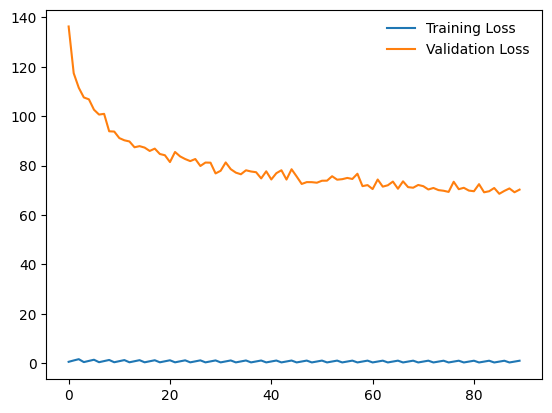

In [17]:
plt.plot(train_losses,label='Training Loss')
plt.plot(valid_losses,label='Validation Loss')
plt.legend(frameon=False)

## Testing the model

Now that the model has been trained, we can check one more time the performance on the validation set.

In [18]:
nnetwork.eval() 
test_losses, test_loss, accuracy = [], 0, 0

with torch.no_grad():
    for images, labels in tqdm(validloader):

        images, labels = images.to(device), labels.to(device) 

        outputs = nnetwork.forward(images)
        test_loss += criterion(outputs,labels)

        ps = torch.exp(outputs)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

        test_losses.append(test_loss/len(validloader))

print('Test Loss: {:.3f}   |   Test Accuracy: {:.2f}'.format(test_loss/sum(test_losses),100*accuracy/len(validloader)))

100%|██████████| 157/157 [00:02<00:00, 57.38it/s]

Test Loss: 1.978   |   Test Accuracy: 70.33


## Saving your model
Using `torch.save`, save your model for future loading.

In [20]:
nnetwork.cpu()
checkpoint_model = {'state_dict': nnetwork.state_dict(),'model_path': model_path}
torch.save(checkpoint_model,'cifar10_model.pth')

## My Recommendation

Given the constraint of the project, and that with a relatively simple model in approximately 22 minutes we achieved a superior accuracy score on our validation data, I would suggest that with more fine tuning and potentially a deeper model we are better off building it in-house. 

Also, we could consider using a pretrained model but I assumed the constraint of the project didn't allow for such a warm start.

In comparison to the literature obviously we are underperforming. However, this model trained on GPU for approximately 22 minutes and achieved results not too dissimilar to the first paper linked. Few things to try:
- make the image larger to capture more details
- make the convolutional side of the network deep (as this will likely add more improvements than the linear side given its capacity to capture more complex relationships in the data)
- increase the number of epochs

## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).